# Qiskit Fall Fest - Introduction to Quantum Error Correction

# Introduction: Beyond Mitigation
Welcome to Notebook 2! In the last session, we learned about Quantum Error Mitigation (QEM), which estimates a noise-free result from noisy runs.

Now, we'll learn about Quantum Error Correction (QEC), the long-term, scalable solution.

The Big Idea: Instead of just estimating the error, we will actively detect and correct it during the computation.

QEM vs. QEC:

QEM (Mitigation): Post-processing. Uses noisy results to estimate the ideal one. Does not protect qubits during computation.

QEC (Correction): Active process. Uses redundancy (many physical qubits) to encode one, robust logical qubit. It finds and fixes errors as they happen.


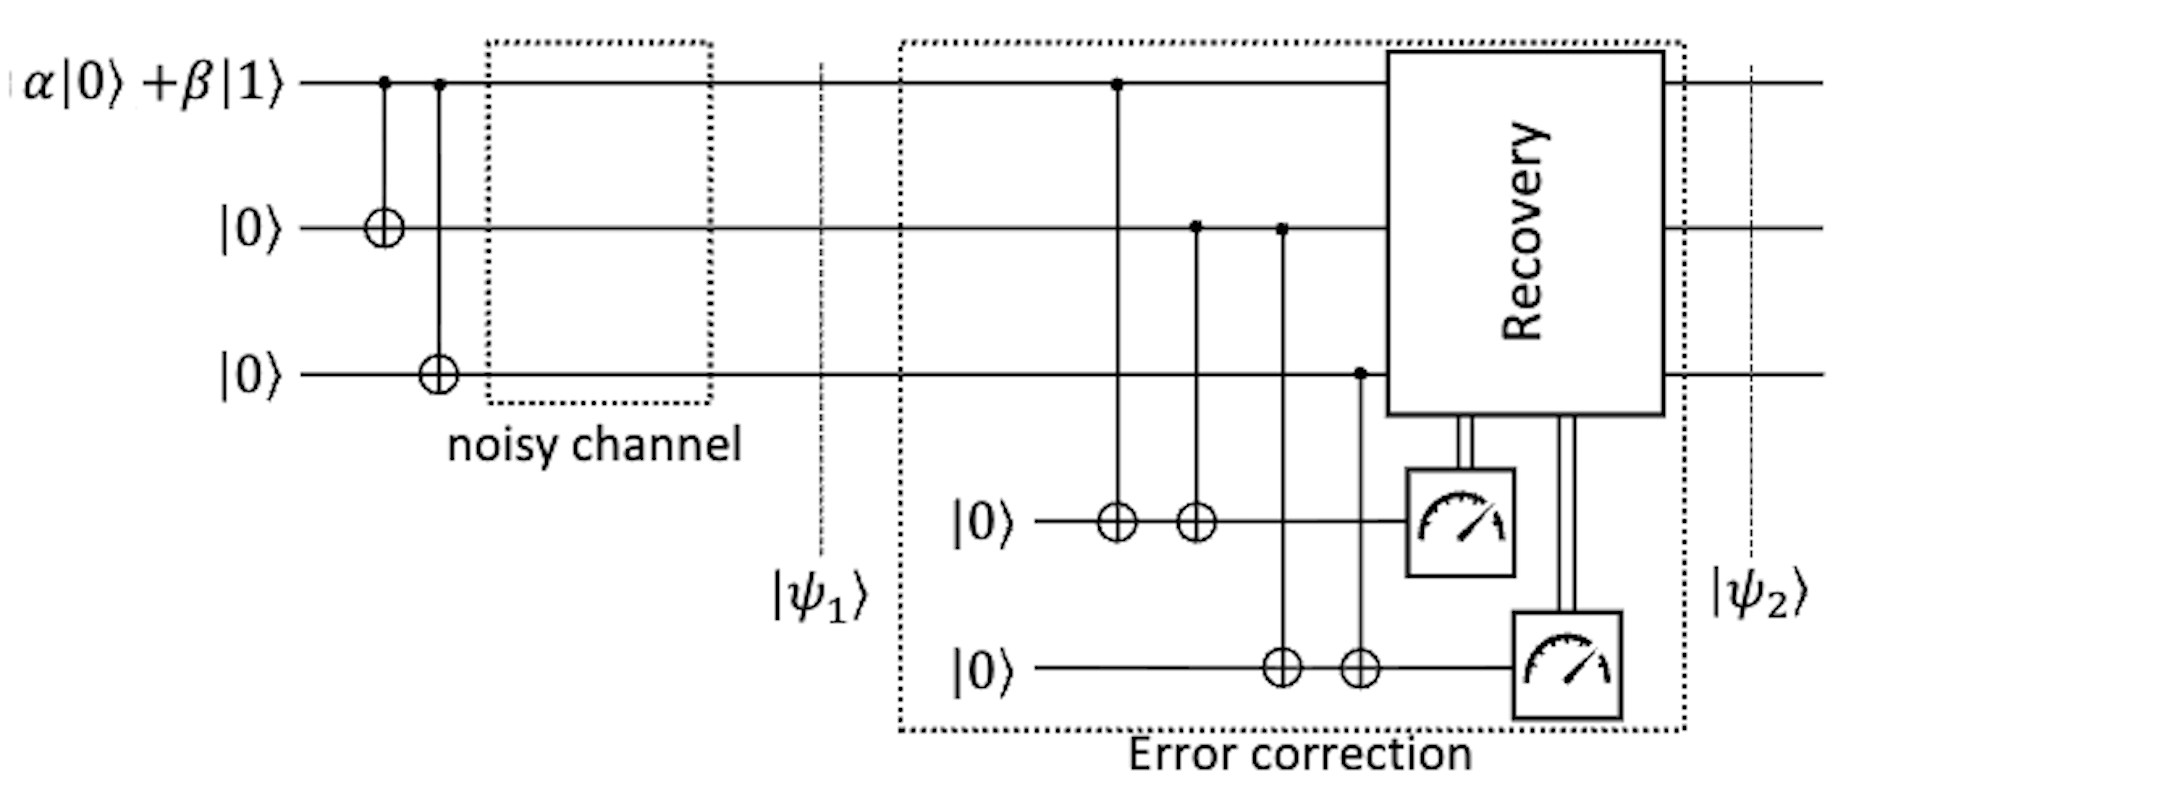

In [ ]:
# Core Qiskit package (includes qiskit-terra, qiskit-aer, qiskit-ibmq-provider, etc.)
!pip install qiskit
# Qiskit Aer simulator backend
!pip install qiskit-aer
# Qiskit Quantum Error Correction tools
!pip install qiskit-qec
# Visualization dependencies (plot_histogram uses matplotlib)
!pip install matplotlib
# Numpy for numerical operations
!pip install numpy

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

# Qiskit QEC package is not installed in this environment.
# To use QEC features, install with: pip install qiskit-qec

# Simulator
sim = AerSimulator()

In [ ]:
# Surpress any warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Section 1: The 3-Qubit Bit-Flip Code

Concept: We can protect against a single bit-flip (X error) by using redundancy. We'll encode our 1-qubit state into 3 qubits.Logical $|0\rangle_L$: $|000\rangle$Logical $|1\rangle_L$: $|111\rangle$

Our logical state will be a superposition: $|\psi\rangle_L = \alpha|000\rangle + \beta|111\rangle$.

If an $X$ error hits qubit 1: $\alpha|000\rangle + \beta|111\rangle \rightarrow \alpha|0\textbf{1}0\rangle + \beta|1\textbf{0}1\rangle$.The state is corrupted! But notice... the "majority vote" is still correct. How do we detect this without measuring?

Syndrome Measurement:We can't measure the data qubits ($q_0, q_1, q_2$) directly, as that would collapse the superposition. Instead, we "ask" them questions using ancilla (helper) qubits.

We check the parity (are they a-pair-of-qubits the same or different?):Check $q_0$ and $q_1$: Measure $Z_0Z_1$.Check $q_1$ and $q_2$: Measure $Z_1Z_2$.

We can do this with CNOTs into two ancilla qubits ($a_0, a_1$):

Syndrome Table (Error $\rightarrow$ Syndrome a1, a0):
- No Error $\rightarrow$ 00
- $X$ on $q_0$ $\rightarrow$ 10
- $X$ on $q_1$ $\rightarrow$ 11
- $X$ on $q_2$ $\rightarrow$ 01

Based on the syndrome, we apply a correction!

## Exercise 1: Build the Bit-Flip Code

Task: Let's build the full QEC circuit.
1. Encode: Start with a logical qubit (q_d[0]) in state $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$. Encode this into the 3-qubit logical state $\frac{|000\rangle + |111\rangle}{\sqrt{2}}$.
2. Error: Manually add an X error to q_d[1].
3. Syndrome: Build the syndrome measurement circuit shown above.
4. Correct: This is the tricky part! We can use c_if to apply a correction based on the classical syndrome bits.

##Registers and circuit setup
QuantumRegister → holds quantum bits (qubits) that store and evolve quantum information.

ClassicalRegister → holds classical bits that store measurement results — (from ancilla)those are ordinary bits you can read and use for conditional logic.

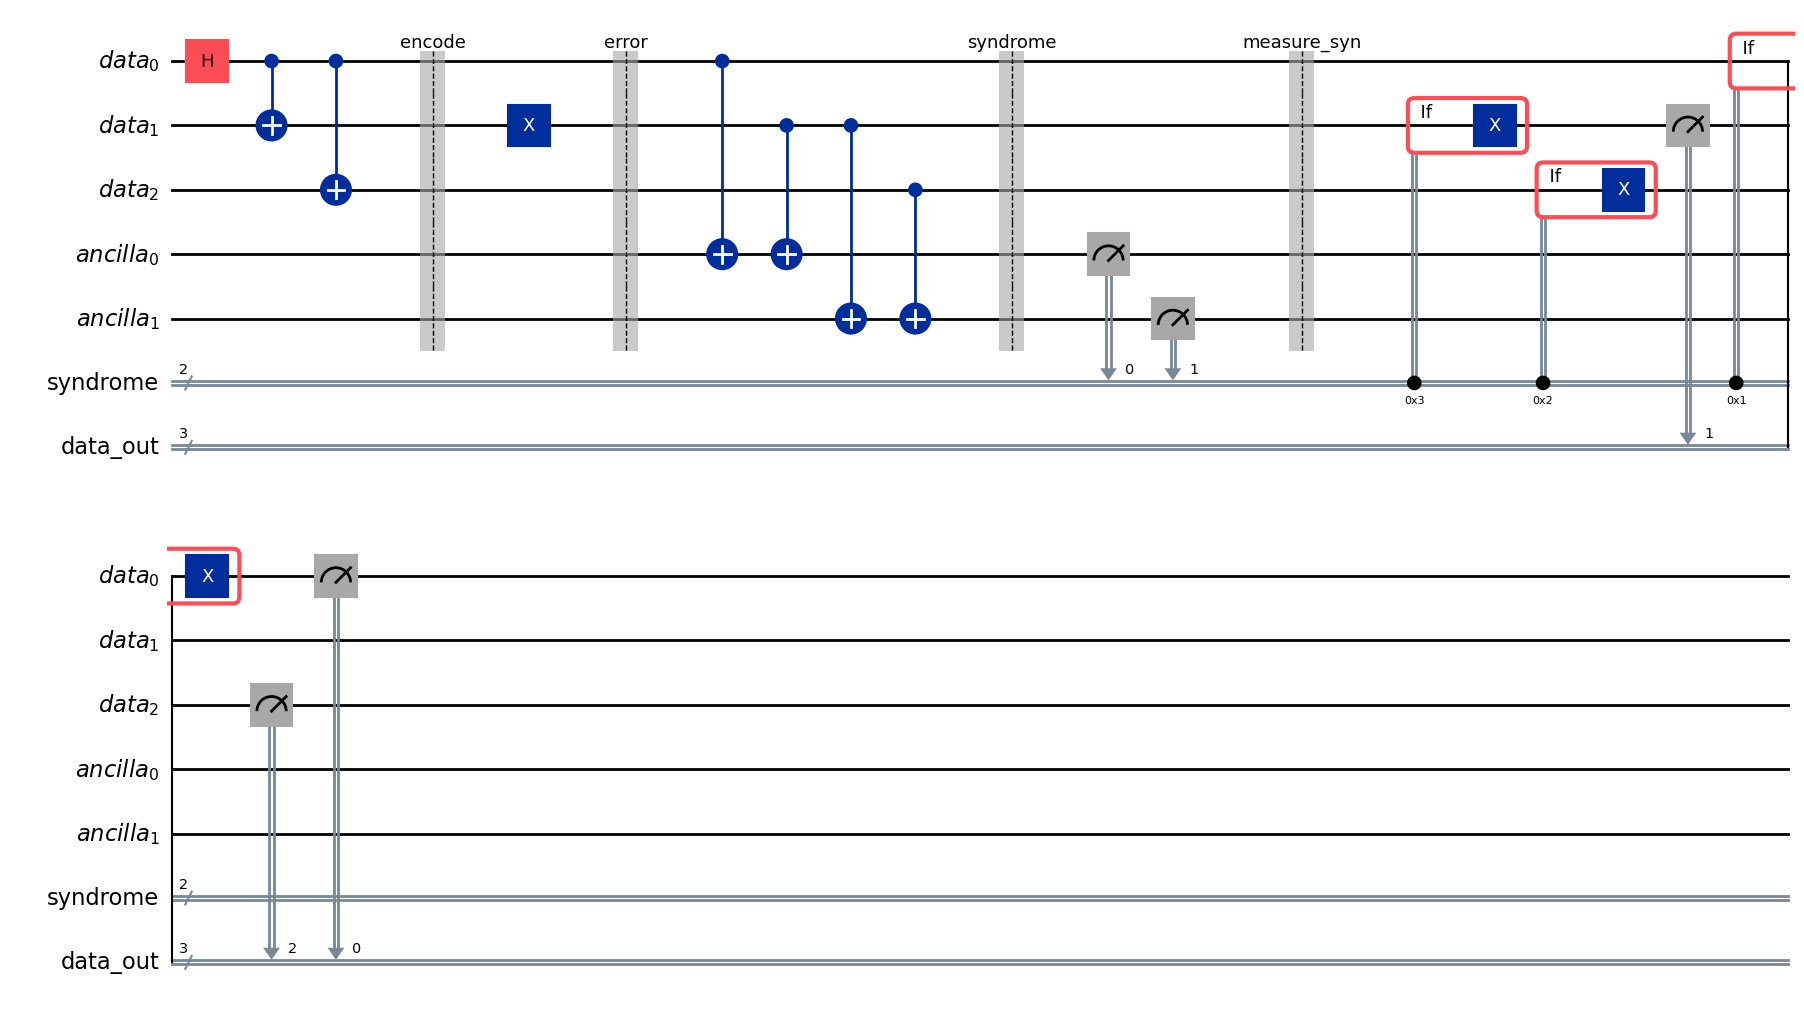

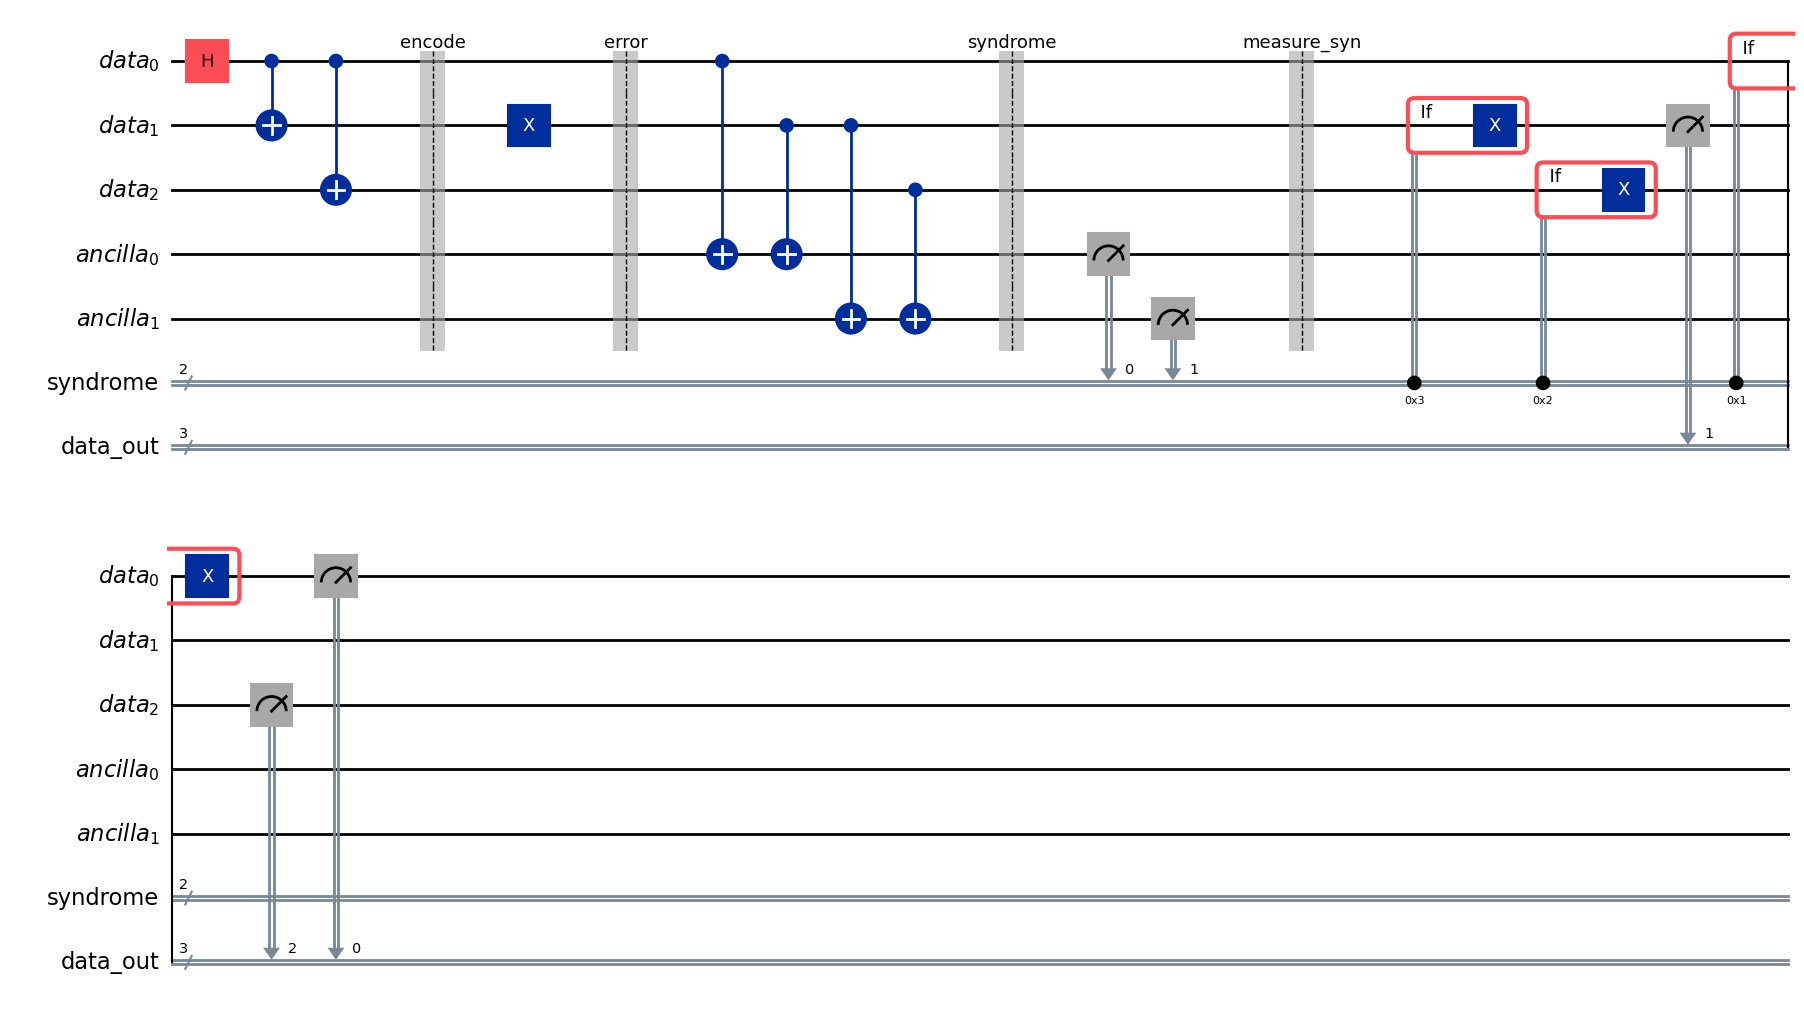

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import XGate

# We need 3 data qubits and 2 ancilla qubits
q_d = QuantumRegister(3, name='data')
q_a = QuantumRegister(2, name='ancilla')#used for measurement of parity
# We need 2 classical bits for the ancilla quibts
c_syn = ClassicalRegister(2, name='syndrome')
# We need 3 classical bits to measure the final data qubits
c_data = ClassicalRegister(3, name='data_out')
#now we have 5 total quibts
qc = QuantumCircuit(q_d, q_a, c_syn, c_data)

# 1. Encode |+> state #superposition
qc.h(q_d[0])
qc.cx(q_d[0], q_d[1])
qc.cx(q_d[0], q_d[2])
qc.barrier(label='encode')

# 2. Add an Error!
qc.x(q_d[1]) # Let's hit the middle qubit
qc.barrier(label='error')

# 3. Syndrome Measurement(parity check)
qc.cx(q_d[0], q_a[0])
qc.cx(q_d[1], q_a[0])
qc.cx(q_d[1], q_a[1])
qc.cx(q_d[2], q_a[1])
qc.barrier(label='syndrome')

# Measure the ancillas into the syndrome register
qc.measure(q_a, c_syn)
qc.barrier(label='measure_syn')

# 4. Correction (Corrected Syntax and Logic)
# 4. Correction (Alternative modern syntax)
with qc.if_test((c_syn, 3)):
    qc.x(q_d[1])
with qc.if_test((c_syn, 2)):
    qc.x(q_d[2])
with qc.if_test((c_syn, 1)):
    qc.x(q_d[0])

# 5. Measure the final, corrected data
qc.measure(q_d, c_data)

# Now this will work/ change to qc.draw('text') if mpl doesnt work
qc.draw('mpl')

##  Exercise 2: Test the Correction
Task: Let's prove our circuit works.

1. Run the circuit: Execute the qc from above on the aer_simulator using Sampler.

2. Analyze: What should the final data_out be? We started with $|+\rangle_L = \frac{|000\rangle + |111\rangle}{\sqrt{2}}$. Even after the error and correction, the final state should be this. Measuring this gives 000 or 111.

3. Remove the error: Comment out qc.x(q_d[1]).

4. Run again: Run the no-error circuit. The data_out should still be 000 or 111.

This proves the code correctly fixes the error when it happens, and does nothing when it doesn't!

###  Your Answer

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram

In [ ]:
# --- Your Code Goes Here ---

# Fill in the Blanks: 3-Qubit Bit-Flip Code (Code Version)

# Complete the code by filling in the blanks (replace ___ with the correct code):

# --- Define Registers ---
q_d = QuantumRegister(___, name='data')
q_a = QuantumRegister(___, name='ancilla')
c_syn = ClassicalRegister(___, name='syndrome')
c_data = ClassicalRegister(___, name='data_out')

# --- Circuit 1: WITH Error ---
qc = QuantumCircuit(q_d, q_a, c_syn, c_data)
qc.h(q_d[___])
qc.cx(q_d[0], q_d[___])
qc.cx(q_d[0], q_d[___])
qc.barrier(label='encode')
qc.x(q_d[___]) # The error
qc.barrier(label='error')
qc.cx(q_d[0], q_a[___])
qc.cx(q_d[___], q_a[0])
qc.cx(q_d[___], q_a[1])
qc.cx(q_d[___], q_a[1])
qc.barrier(label='syndrome')
qc.measure(q_a, c_syn)
qc.barrier(label='measure_syn')
with qc.if_test((c_syn, ___)):
    qc.x(q_d[___])
with qc.if_test((c_syn, ___)):
    qc.x(q_d[___])
with qc.if_test((c_syn, ___)):
    qc.x(q_d[___])
qc.barrier(label='correct')
qc.measure(q_d, c_data)

# --- Simulation Code ---
sim = AerSimulator()
job_with_error = sim.run(qc, shots=___)
result_with_error = job_with_error.result()
counts_with_error = result_with_error.get_counts(qc)
print("Results WITH error and correction")
fig1 = plot_histogram(counts_with_error, title="With Error + Correction")
plt.show()

### 💡 Solution

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram

# --- Define Registers ---
q_d = QuantumRegister(3, name='data')
q_a = QuantumRegister(2, name='ancilla')
c_syn = ClassicalRegister(2, name='syndrome')
c_data = ClassicalRegister(3, name='data_out')

# --- Circuit 1: WITH Error ---
qc = QuantumCircuit(q_d, q_a, c_syn, c_data)
qc.h(q_d[0])
qc.cx(q_d[0], q_d[1])
qc.cx(q_d[0], q_d[2])
qc.barrier(label='encode')
qc.x(q_d[1]) # The error
qc.barrier(label='error')
qc.cx(q_d[0], q_a[0])
qc.cx(q_d[1], q_a[0])
qc.cx(q_d[1], q_a[1])
qc.cx(q_d[2], q_a[1])
qc.barrier(label='syndrome')
qc.measure(q_a, c_syn)
qc.barrier(label='measure_syn')
with qc.if_test((c_syn, 3)):
    qc.x(q_d[1])
with qc.if_test((c_syn, 2)):
    qc.x(q_d[2])
with qc.if_test((c_syn, 1)):
    qc.x(q_d[0])
qc.barrier(label='correct')
qc.measure(q_d, c_data)

# --- Simulation Code ---
sim = AerSimulator()
job_with_error = sim.run(qc, shots=1000)
result_with_error = job_with_error.result()
counts_with_error = result_with_error.get_counts(qc)
print("Results WITH error and correction ")
fig1 = plot_histogram(counts_with_error, title="With Error + Correction")
plt.show()

#  Build a new circuit without the error
qc_no_error = QuantumCircuit(q_d, q_a, c_syn, c_data)
qc_no_error.h(q_d[0])
qc_no_error.cx(q_d[0], q_d[1])
qc_no_error.cx(q_d[0], q_d[2])
qc_no_error.barrier()
# NO ERROR LINE
qc_no_error.barrier()
qc_no_error.cx(q_d[0], q_a[0])
qc_no_error.cx(q_d[1], q_a[0])
qc_no_error.cx(q_d[1], q_a[1])
qc_no_error.cx(q_d[2], q_a[1])
qc_no_error.barrier()
qc_no_error.measure(q_a, c_syn)
qc_no_error.barrier()
with qc_no_error.if_test((c_syn, 3)):
    qc_no_error.x(q_d[1])
with qc_no_error.if_test((c_syn, 2)):
    qc_no_error.x(q_d[2])
with qc_no_error.if_test((c_syn, 1)):
    qc_no_error.x(q_d[0])
qc_no_error.barrier()
qc_no_error.measure(q_d, c_data)

job_no_error = sim.run(qc_no_error, shots=1000)
result_no_error = job_no_error.result()
counts_no_error = result_no_error.get_counts(qc_no_error)
print("\n Results WITHOUT error ")
fig2 = plot_histogram(counts_no_error, title="Without Error")
plt.show()

#Section 2: The 9-Qubit Shor Code
The bit-flip code only fixes $X$ errors. What about $Z$ (phase-flip) errors?

- A phase-flip code is just a bit-flip code in the $H$ basis.

- Encode: $|0\rangle \rightarrow |+++\rangle$, $|1\rangle \rightarrow |---\rangle$

- Syndromes: Measure $X_0X_1$ and $X_1X_2$.

- But what about $Y$ errors? A $Y$ error is $Y = iZX$. It's a bit-flip and a phase-flip.

- The Shor Code combines (concatenates) these two ideas:

- Outer Code (Phase-Flip): First, encode 1 qubit into 3 qubits ($q_0, q_1, q_2$) to protect against phase-flips.

- Inner Code (Bit-Flip): Then, encode each of those 3 qubits into 3 more qubits to protect against bit-flips.
- $q_0 \rightarrow (q_{00}, q_{01}, q_{02})$
- $q_1 \rightarrow (q_{10}, q_{11}, q_{12})$
- $q_2 \rightarrow (q_{20}, q_{21}, q_{22})$

- Total Qubits: 1 (logical) $\rightarrow$ 9 (physical).This code can correct any single-qubit error ($X$, $Y$, or $Z$) on any of the 9 qubits.

In [ ]:
!pip install qiskit

The 9-Qubit Shor Code — Step-by-Step

We’ll build the full circuit gradually:

Encoding

Error injection

Syndrome extraction

Error correction

Verification (decoding and measurement)

## Step 1: Encoding

9 data qubits hold the encoded logical qubit.

8 ancillas record the eight stabilizer measurements (6 for bit-flip, 2 for phase-flip checks).

Classical registers store those results and the final decoded logical measurement.

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# --- Define registers ---
data = QuantumRegister(9, 'data')      # 9 physical qubits
anc = QuantumRegister(8, 'ancilla')    # 8 ancillas for stabilizer measurements
c_syn = ClassicalRegister(8, 'syndrome')
c_out = ClassicalRegister(1, 'logical_out')

qc = QuantumCircuit(data, anc, c_syn, c_out)

Spreads the logical qubit’s phase information into three qubits —
𝑞0,𝑞3,𝑞6

###phase flip (outer) encoding
This spreads the logical qubit’s phase information into three qubits —
𝑞
0
,
𝑞
3
,
𝑞
6.

In [ ]:
# Encode 1 logical qubit into 3 for phase-flip protection
qc.h(data[0])          # Move into X-basis
qc.cx(data[0], data[3])
qc.cx(data[0], data[6])
qc.barrier(label='phase-flip encoding')

### bit flip encoding(inner)
### Each of the three phase-encoded qubits is now expanded into its own 3-qubit bit-flip code block.
### Now we have 9 data qubits holding the fully encoded logical state:

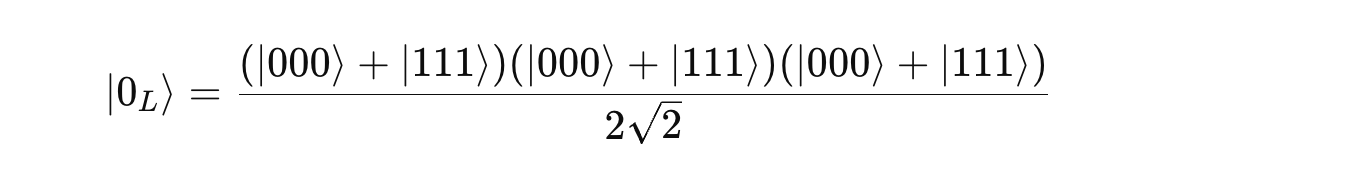

In [15]:
# Encode each of those 3 into 3 more for bit-flip protection
for block_start in [0, 3, 6]:
    qc.cx(block_start, block_start+1)
    qc.cx(block_start, block_start+2)

qc.barrier(label='bit-flip encoding')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=17, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "data"), index=0>, <Qubit register=(9, "data"), index=1>, <Qubit register=(9, "data"), index=2>, <Qubit register=(9, "data"), index=3>, <Qubit register=(9, "data"), index=4>, <Qubit register=(9, "data"), index=5>, <Qubit register=(9, "data"), index=6>, <Qubit register=(9, "data"), index=7>, <Qubit register=(9, "data"), index=8>, <Qubit register=(8, "ancilla"), index=0>, <Qubit register=(8, "ancilla"), index=1>, <Qubit register=(8, "ancilla"), index=2>, <Qubit register=(8, "ancilla"), index=3>, <Qubit register=(8, "ancilla"), index=4>, <Qubit register=(8, "ancilla"), index=5>, <Qubit register=(8, "ancilla"), index=6>, <Qubit register=(8, "ancilla"), index=7>), clbits=())

## Step 2: Introduce an Error

We can inject an
𝑋
,
𝑌,
Z error on any one of the nine data qubits.
This mimics noise in a real quantum device.
A  𝑌 error combines both bit and phase flips — the hardest single-qubit error.
The Shor code should detect and correct it.

In [16]:
# Inject a Y error (bit-flip + phase-flip) on qubit 4
qc.y(data[4])
qc.barrier(label='error')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=17, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "data"), index=0>, <Qubit register=(9, "data"), index=1>, <Qubit register=(9, "data"), index=2>, <Qubit register=(9, "data"), index=3>, <Qubit register=(9, "data"), index=4>, <Qubit register=(9, "data"), index=5>, <Qubit register=(9, "data"), index=6>, <Qubit register=(9, "data"), index=7>, <Qubit register=(9, "data"), index=8>, <Qubit register=(8, "ancilla"), index=0>, <Qubit register=(8, "ancilla"), index=1>, <Qubit register=(8, "ancilla"), index=2>, <Qubit register=(8, "ancilla"), index=3>, <Qubit register=(8, "ancilla"), index=4>, <Qubit register=(8, "ancilla"), index=5>, <Qubit register=(8, "ancilla"), index=6>, <Qubit register=(8, "ancilla"), index=7>), clbits=())

## Step 3: Syndrome Measurement

### Bit-flip (Z-type) stabilizers

Each 3-qubit block is protected from bit-flips by measuring:

𝑍
0
𝑍
1
,

𝑍
1
𝑍
2
,

𝑍
3
𝑍
4
,

𝑍
4
𝑍
5
,

𝑍
6
𝑍
7
,

𝑍
7
𝑍
8

Each ancilla flips if exactly one of the two data qubits is 1 (detecting differing parity).

A 1 result indicates a bit-flip error in that block.

In [ ]:
# Measure Z-type (bit-flip) stabilizers
for i, (q1, q2) in enumerate([(0,1),(1,2),(3,4),(4,5),(6,7),(7,8)]):
    qc.cx(data[q1], anc[i])
    qc.cx(data[q2], anc[i])
    qc.measure(anc[i], c_syn[i])
qc.barrier(label='Z-type syndromes')


### Phase-flip (X-type) stabilizers

For phase-flips, we use Hadamards to move into the X-basis and measure across the three blocks:

𝑋
0
𝑋
3
𝑋
6
,
𝑋
2
𝑋
5
𝑋8
Hadamards convert phase information into measurable bit information.

Ancillas record parity across blocks — 1 indicates a phase-flip mismatch.


In [ ]:
# Measure X-type (phase-flip) stabilizers
qc.h(data)
for j, group in enumerate([[0,3,6],[2,5,8]], start=6):
    for q in group:
        qc.cx(data[q], anc[j])
    qc.measure(anc[j], c_syn[j])
qc.h(data)
qc.barrier(label='X-type syndromes')

## Step 4: Correction Logic

For our demo, you can manually interpret them:

Error type->	Typical syndrome ->pattern	Correction

Bit-flip (X)->	One Z-type ancilla = 1	->Apply X on that qubit

Phase-flip (Z)->	One X-type ancilla = 1	->Apply Z on that qubit

Y-error	->Both kinds triggered->	Apply both X and Z

## Step 5:Verification (Decoding and Measurement)
After correction, decode (reverse encoding) to get the logical qubit back:

This unravels the encoding to extract the logical qubit.

If the code worked, you’ll recover the same logical state as before the error.

In [13]:
# --- Optional decoding (reverse of encoding) ---
for block_start in [0,3,6]:
    qc.cx(block_start, block_start+1)
    qc.cx(block_start, block_start+2)
qc.barrier(label='decode bit-flip')

qc.cx(data[0], data[3])
qc.cx(data[0], data[6])
qc.h(data[0])
qc.barrier(label='decode phase-flip')

# Measure logical output qubit
qc.measure(data[0], c_out[0])
qc.draw('text')


┌───┐           phase-flip encoding           »
       data_0: ┤ H ├──■────■────────────░────────────■────■──»
               └───┘  │    │            ░          ┌─┴─┐  │  »
       data_1: ───────┼────┼────────────░──────────┤ X ├──┼──»
                      │    │            ░          └───┘┌─┴─┐»
       data_2: ───────┼────┼────────────░───────────────┤ X ├»
                    ┌─┴─┐  │            ░               └───┘»
       data_3: ─────┤ X ├──┼────────────░────────────■────■──»
                    └───┘  │            ░          ┌─┴─┐  │  »
       data_4: ────────────┼────────────░──────────┤ X ├──┼──»
                           │            ░          └───┘┌─┴─┐»
       data_5: ────────────┼────────────░───────────────┤ X ├»
                         ┌─┴─┐          ░               └───┘»
       data_6: ──────────┤ X ├──────────░────────────■────■──»
                         └───┘          ░          ┌─┴─┐  │  »
       data_7: ─────────────────────────░──────────┤ X ├──┼──»
                                        ░          └───┘┌─┴─┐»
       data_8: ─────────────────────────░───────────────┤ X ├»
                                        ░               └───┘»
    ancilla_0: ─────────────────────────░────────────────────»
                                        ░                    »
    ancilla_1: ─────────────────────────░────────────────────»
                                        ░                    »
    ancilla_2: ─────────────────────────░────────────────────»
                                        ░                    »
    ancilla_3: ─────────────────────────░────────────────────»
                                        ░                    »
    ancilla_4: ─────────────────────────░────────────────────»
                                        ░                    »
    ancilla_5: ─────────────────────────░────────────────────»
                                        ░                    »
    ancilla_6: ─────────────────────────░────────────────────»
                                        ░                    »
    ancilla_7: ─────────────────────────░────────────────────»
                                        ░                    »
   syndrome: 8/══════════════════════════════════════════════»
                                                             »
logical_out: 1/══════════════════════════════════════════════»
                                                             »
«                bit-flip encoding       error                               »
«       data_0: ─────────░─────────────────░─────■───────────────────────────»
«                        ░                 ░     │                           »
«       data_1: ─────────░─────────────────░─────┼──────────────■────────────»
«                        ░                 ░     │              │            »
«       data_2: ─────────░─────────────────░─────┼──────────────┼────────────»
«                        ░                 ░     │              │            »
«       data_3: ─────────░─────────────────░─────┼────■─────────┼────────────»
«                        ░         ┌───┐   ░     │    │         │            »
«       data_4: ─────────░─────────┤ Y ├───░─────┼────┼─────────┼────■───────»
«                        ░         └───┘   ░     │    │         │    │       »
«       data_5: ─────────░─────────────────░─────┼────┼─────────┼────┼───────»
«                        ░                 ░     │    │         │    │       »
«       data_6: ─────────░─────────────────░─────┼────┼────■────┼────┼───────»
«                        ░                 ░     │    │    │    │    │       »
«       data_7: ─────────░─────────────────░─────┼────┼────┼────┼────┼────■──»
«                        ░                 ░     │    │    │    │    │    │  »
«       data_8: ─────────░─────────────────░─────┼────┼────┼────┼────┼────┼──»
«                        ░                 ░   ┌─┴─┐  │    │  ┌─┴─┐  │    │  »
«    ancilla_0: ─────────░─────────────────░───┤ X ├──┼──

#Your Task
Task:

Import RepetitionCode from qiskit_qec.codes.

Create a code with d=3 (distance 3, our 3-qubit code) and T=1 (1 round of syndrome measurement).

Draw the circuit!

# Section 3: The Future - Surface Codes & qiskit_qec

The Shor code is not very efficient (9 qubits for 1). The most promising codes for fault-tolerance are Surface Codes.

Concept:
- Qubits are arranged on a 2D grid.

- We measure local stabilizers (e.g., $ZZZZ$ on "data" plaquettes and $XXXX$ on "syndrome" plaquettes) over and over.

- Errors create "defects" in the syndrome, and a complex classical decoder (like "minimum-weight perfect matching") figures out where the errors most likely occurred.

- The qiskit_qec Package:Qiskit has a brand-new package dedicated to QEC! It has built-in definitions for many codes.

- Task: Let's use qiskit_qec to define our 3-qubit bit-flip code (which it calls a RepetitionCode).

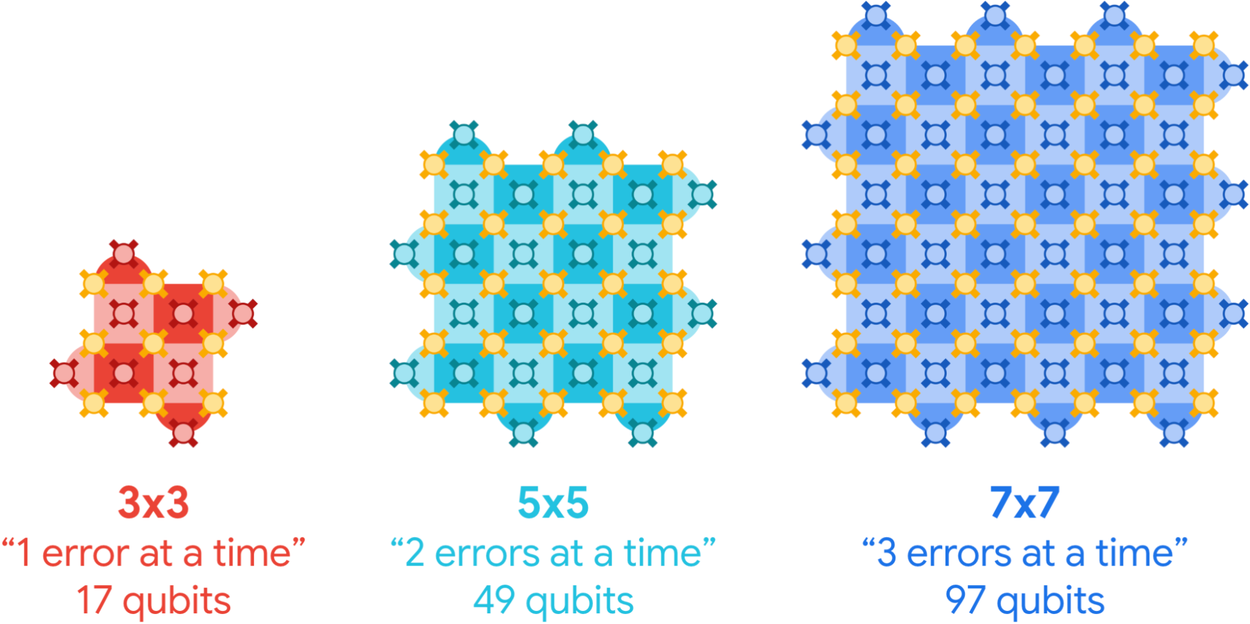

In [ ]:
# --- Your Code Goes Here ---
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Define registers
q_d = QuantumRegister(_, name='data')
q_a = QuantumRegister(_, name='ancilla')
c_syn = ClassicalRegister(_, name='syndrome')
c_data = ClassicalRegister(_, name='data_out')

# Build the circuit
qc = QuantumCircuit(q_d, q_a, c_syn, c_data)
qc.h(q_d[_])
qc.cx(q_d[_], q_d[_])
qc.cx(q_d[0], q_d[2])
qc.barrier(label='encode')
# (Optional) Add error here if desired, e.g. qc.x(q_d[1])
qc.barrier(label='error')
qc.cx(_)#######                             @###)
qc.cx(q_)
qc.cx(_)
qc.cx(_)
qc.barrier(label='syndrome')
qc.measure(q_a, c_syn)
qc.barrier(label='measure_syn')
with qc.if_test((c_syn, 3)):
    qc.x(q_d[1])
with qc.if_test((c_syn, 2)):
    qc.x(q_d[2])
with qc.if_test((c_syn, 1)):
    qc.x(q_d[0])
qc.barrier(label='correct')
qc.measure(q_d, c_data)

# Draw the circuit
qc.draw('mpl')

### 💡 Solution

In [ ]:
# --- Solution Code: Manual 3-Qubit Bit-Flip Code (Qiskit Core) ---
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Define registers
q_d = QuantumRegister(3, name='data')
q_a = QuantumRegister(2, name='ancilla')
c_syn = ClassicalRegister(2, name='syndrome')
c_data = ClassicalRegister(3, name='data_out')

# Build the circuit
qc = QuantumCircuit(q_d, q_a, c_syn, c_data)
qc.h(q_d[0])
qc.cx(q_d[0], q_d[1])
qc.cx(q_d[0], q_d[2])
qc.barrier(label='encode')
# (Optional) Add error here if desired, e.g. qc.x(q_d[1])
qc.barrier(label='error')
qc.cx(q_d[0], q_a[0])
qc.cx(q_d[1], q_a[0])
qc.cx(q_d[1], q_a[1])
qc.cx(q_d[2], q_a[1])
qc.barrier(label='syndrome')
qc.measure(q_a, c_syn)
qc.barrier(label='measure_syn')
with qc.if_test((c_syn, 3)):
    qc.x(q_d[1])
with qc.if_test((c_syn, 2)):
    qc.x(q_d[2])
with qc.if_test((c_syn, 1)):
    qc.x(q_d[0])
qc.barrier(label='correct')
qc.measure(q_d, c_data)

# Draw the circuit
qc.draw('mpl')

This package lets you build complex circuits for error correction and decoding with just a few lines of code!

# Conclusion
You've now mastered the fundamentals of Quantum Error Correction!

You learned:

QEC actively detects and corrects errors, unlike QEM.

This is achieved through redundancy (logical qubits) and syndrome measurements.

We built the 3-qubit bit-flip code from scratch.

We learned the theory of the 9-qubit Shor code, which can fix any single-qubit error.

We were introduced to Surface Codes and the qiskit_qec package, which are the future of fault-tolerant quantum computing.

You are now well-equipped to understand the cutting-edge research happening in quantum computing. Great job!